# Expectation Maximization and Principal Component Analysis

Contents:

1. Mixture of Gaussians: Expectation-Maximization
    - Display results
    - Nearest Centroid-based classification
2. Principal Component Analysis
    - Generate data
    - Apply PCA
    - Display projection

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal, norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

#### We use `iris` dataset from `sklearn` library

(<matplotlib.collections.PathCollection at 0x151fd598dd0>,
 <matplotlib.legend.Legend at 0x151fd5a67d0>)

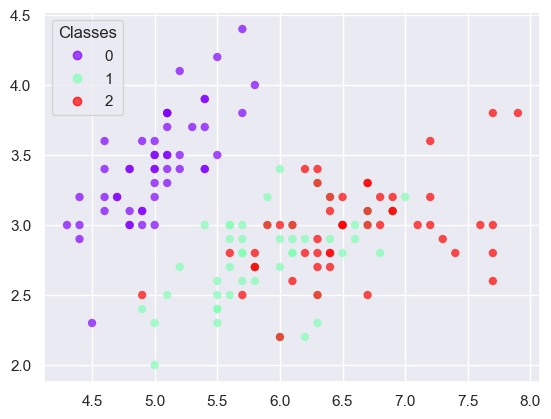

In [2]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

## 1) Mixture of Gaussians: Expectation-Maximization

Function `gaussian_mixture` that takes data point `x` (say, a vector in D-dimensional space), set of multivariate `means` and respective `covariances`, and `pis` (mixing coefficients as defined in a Gaussian mixture model) and returns PDF value of mixture model at the point x.

In [3]:
def gaussian_mixture(x, means, covariances, pis):
    K = len(means)
    mixed_gaussians = np.array([pis[i]*multivariate_normal.pdf(x, mean=means[i], cov=covariances[i]) for i in range(K)])
    return np.sum(mixed_gaussians)

Function `expectation_maximization_gaussian` that takes initial mean vectors `mus_0`, initial covariance matrices `covariances_0`, initial mixing coefficient values `pis_0`, input data set `data_x` and a callback `on_step`.

The `on_step` is a function that takes current set of `mus`, corresponding `covariances` and `pis`, value of `log_likelihood` and list of class `predictions` for each point and should be called each iteration step. Remember that you do not need to define this function as it has already been defined in the later part of the code, you just need to call it after updating parameters in each iteration.

In [4]:
def expectation_maximization_gaussian(mus_0, covariances_0, pis_0, data_x, on_step):
    tol = 0.01
    N, D = data_x.shape
    K = len(mus_0)
    
    mus = np.array(mus_0)
    covariances = np.array(covariances_0)
    pis = np.array(pis_0)
    log_likelihood = float("inf")
    responsibilities = np.zeros((N, K))
    
    while True: 
        # E
        for n in range(N):
            for k in range(K):
                responsibilities[n, k] = pis[k] * multivariate_normal.pdf(data_x[n], mus[k], covariances[k])
        
        responsibilities_sum = np.sum(responsibilities, axis=1)[:, np.newaxis]
        responsibilities = responsibilities/responsibilities_sum
        
        # M
        N_ks = np.sum(responsibilities, axis=0)
        mus = (responsibilities.T @ data_x) / N_ks[:, np.newaxis]
        
        for k in range(K):
            Nk = N_ks[k]
            diff = data_x - mus[k]
            weighted_sum = np.zeros((D, D))
            for n in range(N):
                diff_n = diff[n].reshape(-1, 1)
                weighted_sum += responsibilities[n, k] * (diff_n @ diff_n.T)

            covariances[k] = weighted_sum / Nk
            
        pis = N_ks / N
        new_log_likelihood = np.sum(np.log(responsibilities_sum))
        predictions = np.argmax(responsibilities, axis=1)
        
        on_step(mus, covariances, pis, log_likelihood, predictions)

        if abs(log_likelihood - new_log_likelihood) < tol:
            break
        
        log_likelihood = new_log_likelihood

### 1.1) Display results

In [5]:
def plot_gaussian_mixtures(mus, covariances, pis, data, classes, cmap='rainbow', target=plt):
    
    lx = min(data[:, 0])
    rx = max(data[:, 0])
    by = min(data[:, 1])
    uy = max(data[:, 1])

    x, y = np.mgrid[lx:rx:.01, by:uy:.01]
    pos = np.dstack((x, y))
    
    probabilities = list(map(
        lambda x: gaussian_mixture(x, mus, covariances, pis),
        pos
    ))
    
    target.contour(x, y, probabilities, cmap=cmap)
    
    plot = plot_iris(classes=classes, target=target)
    # scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='data', s=300, edgecolors='black')
    return (*plot, )


def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

Here, we define our initial means `mus_0`, covariance matrices `covariances_0`, mixing coefficient values `pis_0` and call the `expectation_maximization_gaussian function`.

In [6]:
np.random.seed(26)

classes = 3

all_steps_em = []

mus_0 = iris_x[:classes]
covariances_0 = np.array([np.cov(iris_x.T)] * classes)
pis_0 = np.array([1/classes] * classes)

expectation_maximization_gaussian(
    mus_0, covariances_0, pis_0, iris_x,
    lambda mus, covs, pis, log_likelihood, predictions: all_steps_em.append((mus, covs, pis, log_likelihood, predictions))
)

In [7]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
                
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

#create_animation(all_steps_em, iris_x)

### 1.2) Nearest Centroid-based classification

The `nearest_centroid_based_class` takes (a possibly D-dimensional) data point `x`, a set of (a possibly D-dimensional) means `mus` and (a set of DxD dimensional) `covariances` and returns the predicted class of this data point based on nearest centroid based classification.

In [8]:
def nearest_centroid_based_class(x, mus, covariances):
    min_distance = float('inf')
    nearest_class = None
    
    for i, mu in enumerate(mus):
        distance = np.linalg.norm(x, mu)
        #I found this way of calculating a distance including the covariance but not sure if this is what is intended to be used
        #diff = x - mu
        #cov_inv = np.linalg.inv(covariances[i])
        #distance = np.sqrt(np.dot(np.dot(diff, cov_inv), diff.T)) 
            
        if distance < min_distance:
            min_distance = distance
            nearest_class = i
            
    return nearest_class

In [9]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
        
        plot_mesh(
            lambda x: nearest_centroid_based_class(x, all_steps_em[i][0], all_steps_em[i][1]),
            n_class=len(all_steps_em[i][0]), target=ax
        )
        
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

#create_animation(all_steps_em, iris_x)

## 2) Principal Component Analysis

### 2.1) Generate data

In [10]:
iris4_x = np.array(iris.data[:, :4])

def plot_classes_3d(data, classes):

    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    fig.add_axes(ax)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=classes,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    plt.show()

### 2.3) Apply PCA

Function `pca_projection` that takes input data points `data`, desired number of `components` as arguments and returns the PCA projection of the `data`.

In [11]:
def pca_projection(data, components):
    cov = np.cov(data.T)
    
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    biggest_PCs = np.argsort(-eigenvalues)[:components]
    U = eigenvectors[:, biggest_PCs]
    new_data = np.array([U.T @ x for x in data])
    return new_data

### 2.4) Display projection

(<matplotlib.collections.PathCollection at 0x151fdef38d0>,
 <matplotlib.legend.Legend at 0x151fde60d10>)

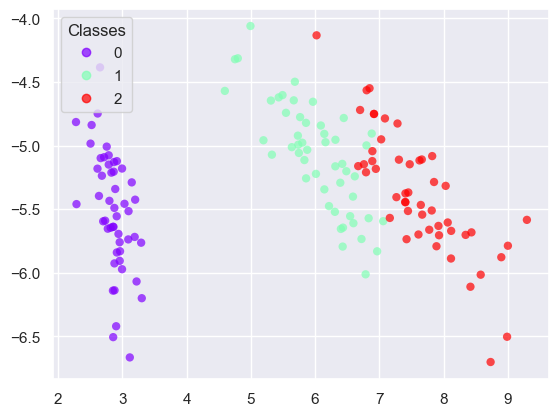

In [12]:
def plot_classes(data, classes, legend=True, target=plt):
    scatter = target.scatter(data[:, 0], data[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

projected_data = pca_projection(iris4_x, 2)
plot_classes(projected_data, iris_t)

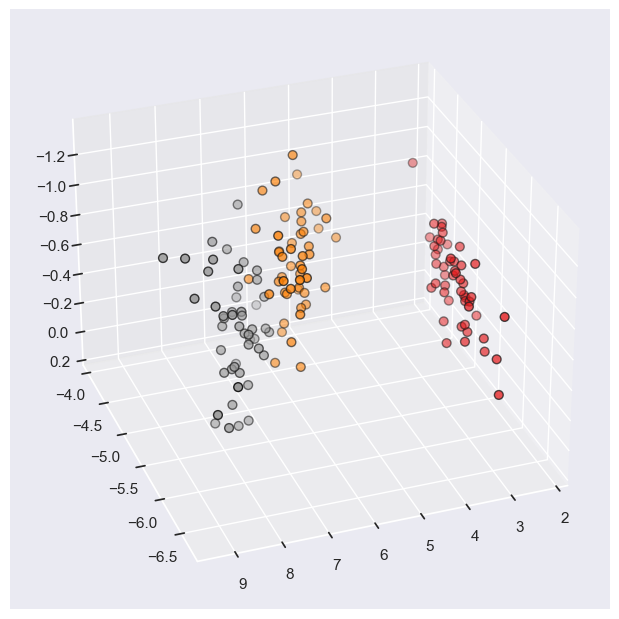

In [13]:
projected_data = pca_projection(iris4_x, 3)
plot_classes_3d(projected_data, iris_t)